In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

### Aux

In [18]:
def load_pkl(file_path):
    return pd.read_pickle(file_path)

In [19]:
def load_all_subjects(folder):
    all_dfs = []
    for fname in os.listdir(folder):
        if fname.endswith(".pkl"):
            path = os.path.join(folder, fname)
            df = pd.read_pickle(path)
            df["subj"] = fname.replace(".pkl", "")
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

In [ ]:
def average_metrics_over_subjects(df):
    # metricas en las que 0 significa que no hubo fijacion -> van a NAN para que no se tengan en cuenta
    duration_metrics = ["FFD", "SFD", "FPRT", "RPD", "TFD", "RRT", "SPRT"]
    df[duration_metrics] = df[duration_metrics].replace(0, np.nan)
    # sacar las excluded
    df = df[df["excluded"] == False]
    # hacer la media por id en oracion, id de palabra y palabra
    mean_df = df.groupby(["sentence_idx", "word_idx", "word"], as_index=False).mean(numeric_only=True)
    
    return mean_df

### Un sujeto de cada uno

In [21]:
# un sujeto original
data_og = load_pkl("results_original/measures/Axolotl/DG01.pkl")
data_og.head(10)

,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,DG01,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN
1,DG01,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000
2,DG01,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.000000,0.000000
3,DG01,1,3,en,0,3,3,False,0,0,0,0,0,0,0,0,0,0.545455,0.000000
4,DG01,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,0.727273,0.000000
5,DG01,1,5,yo,0,5,5,False,225,0,425,0,425,-425,0,2,0,0.272727,0.090909
6,DG01,1,6,pensaba,0,6,6,False,0,0,0,0,0,0,0,0,0,0.818182,0.181818
7,DG01,1,7,mucho,0,7,7,False,175,175,175,0,175,-175,0,1,0,0.272727,0.090909
8,DG01,1,8,en,0,8,8,False,0,0,0,0,0,0,0,0,0,0.636364,0.181818
9,DG01,1,9,los,0,9,9,False,250,250,250,0,250,-250,0,1,0,0.090909,0.181818


In [22]:
# un sujeto de ob1
data_ob1 = load_pkl("results_ob1_normal_1/measures/Axolotl/DG01.pkl")
data_ob1.head(10)

,subj,screen,word_idx,word,sentence_idx,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,DG01,1,0,hubo,0,0,0,True,0,0,0,0,0,0,0,0,0,NaN,NaN
1,DG01,1,1,un,0,1,1,False,0,0,0,0,0,0,0,0,0,1.0,0.0
2,DG01,1,2,tiempo,0,2,2,False,0,0,0,0,0,0,0,0,0,1.0,0.0
3,DG01,1,3,en,0,3,3,False,0,0,0,0,0,0,0,0,0,1.0,0.0
4,DG01,1,4,que,0,4,4,False,0,0,0,0,0,0,0,0,0,1.0,0.0
5,DG01,1,5,yo,0,5,5,False,225,0,425,0,425,-425,0,2,0,0.0,0.0
6,DG01,1,6,pensaba,0,6,6,False,0,0,0,0,0,0,0,0,0,1.0,0.0
7,DG01,1,7,mucho,0,7,7,False,175,175,175,0,175,-175,0,1,0,0.0,0.0
8,DG01,1,8,en,0,8,8,False,0,0,0,0,0,0,0,0,0,1.0,0.0
9,DG01,1,9,los,0,9,9,False,250,250,250,0,250,-250,0,1,0,0.0,0.0


In [23]:
np.corrcoef(data_og['FFD'].values, data_ob1['FFD'].values)

array([[1., 1.],
       [1., 1.]])

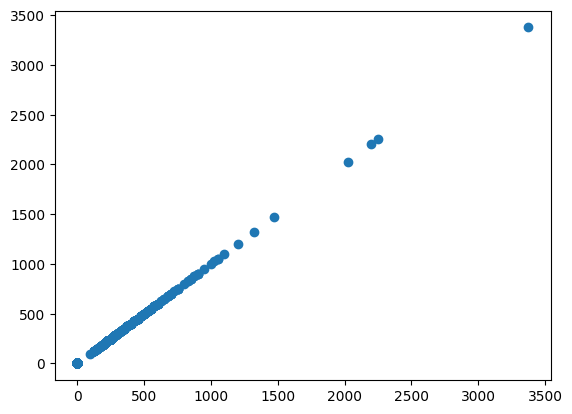

In [24]:
plt.scatter(data_og['FPRT'].values, data_ob1['FPRT'].values)

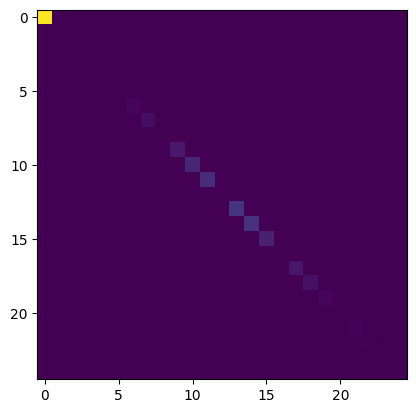

In [25]:
heatmap, xedges, yedges = np.histogram2d(data_og['FFD'].values, data_ob1['FFD'].values, bins=25)
plt.imshow(heatmap.T)

### Toos los sujetos originales vs uno de OB1

In [ ]:
# medias de todos los sujetos originales
folder = "results_original/measures/Axolotl"
all_data = load_all_subjects(folder)
mean_metrics_original = average_metrics_over_subjects(all_data)
# ob1
#folder = "results_ob1_normal_1/measures/Axolotl"
#all_data= load_all_subjects(folder)
#mean_metrics_ob1 = average_metrics_over_subjects(all_data)

In [27]:
mean_metrics_original

,sentence_idx,word_idx,word,screen,sentence_pos,screen_pos,excluded,FFD,SFD,FPRT,RPD,TFD,RRT,SPRT,FC,RC,LS,RR
0,0,1,un,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000
1,0,2,tiempo,1.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000
2,0,3,en,1.0,3.0,3.0,0.0,183.000000,183.000000,183.000000,NaN,183.000000,-183.000000,NaN,0.454545,0.000000,0.545455,0.000000
3,0,4,que,1.0,4.0,4.0,0.0,142.333333,142.333333,142.333333,NaN,142.333333,-142.333333,NaN,0.272727,0.000000,0.727273,0.000000
4,0,5,yo,1.0,5.0,5.0,0.0,162.875000,158.800000,198.125000,182.000000,220.875000,-175.375000,182.000000,1.000000,0.090909,0.272727,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,106,1968,a,24.0,27.0,5.0,0.0,231.333333,246.333333,297.166667,195.600000,345.125000,-100.625000,195.600000,1.181818,0.454545,0.454545,0.454545
1545,106,1969,escribir,24.0,28.0,6.0,0.0,211.222222,211.500000,240.111111,571.600000,456.272727,63.363636,571.600000,2.272727,1.272727,0.181818,0.454545
1546,106,1970,todo,24.0,29.0,7.0,0.0,274.333333,245.666667,285.777778,372.666667,369.000000,-145.400000,372.666667,1.545455,0.636364,0.181818,0.272727
1547,106,1972,sobre,24.0,31.0,9.0,0.0,189.700000,194.000000,212.100000,232.000000,256.090909,-129.545455,232.000000,1.272727,0.272727,0.090909,0.272727
